<a href="https://colab.research.google.com/github/oliverwsd/finance/blob/master/ProblemSet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import numpy as np
import pandas as pd
from io import StringIO
import csv
 
url = 'https://raw.githubusercontent.com/oliverwsd/finance/master/price_data.csv'
prices = pd.read_csv(url,parse_dates= ['Date'])
prices.head

<bound method NDFrame.head of            Date  VBTIX       GE       WMT       IBM      SPX
0    1999-12-31    NaN  49.5795   69.1250  107.8750  1469.25
1    2000-01-03    NaN  48.0577   66.8750  115.6250  1455.22
2    2000-01-04    NaN  46.1955   64.2500  112.0625  1399.42
3    2000-01-05    NaN  45.9552   63.0000  116.0000  1402.11
4    2000-01-06    NaN  46.6710   63.6875  115.0000  1403.45
...         ...    ...      ...       ...       ...      ...
5146 2019-09-23  84.25   9.3400  117.6200  142.0700  2991.78
5147 2019-09-24  84.54   8.9700  118.4000  141.6800  2966.60
5148 2019-09-25  84.14   9.1600  118.4700  143.1600  2984.87
5149 2019-09-26  84.28   9.0200  118.3000  143.5500  2977.62
5150 2019-09-27  84.37   9.0400  118.4500  143.2400  2961.79

[5151 rows x 6 columns]>

In [0]:
returns = prices.copy()
returns.loc[:, ['VBTIX', 'GE', 'WMT', 'IBM', 'SPX']] = np.log(returns.loc[:, ['VBTIX', 'GE', 'WMT', 'IBM', 'SPX']]) - np.log(returns.loc[:, ['VBTIX', 'GE', 'WMT', 'IBM', 'SPX']].shift())

avg_ret_annual = returns.loc[:, ['VBTIX', 'GE', 'WMT', 'IBM', 'SPX']].mean(axis = 0) * 252
std_annual = returns.loc[:, ['VBTIX', 'GE', 'WMT', 'IBM', 'SPX']].std(axis = 0, ddof = 0) * (252**0.5)


In [102]:
mu = np.matrix(avg_ret_annual).T
mu.shape   # Hint: The shape should be (5, 1)
mu

matrix([[ 0.0088722 ],
        [-0.08327833],
        [ 0.02635355],
        [ 0.0138746 ],
        [ 0.0343034 ]])

In [103]:
std_annual

VBTIX    0.044440
GE       0.307701
WMT      0.232419
IBM      0.253736
SPX      0.186346
dtype: float64

In [104]:
volatility_matrix = np.diag(std_annual)                  # This is the diagonal matrix of the volatilities
# Cov = np.dot(volatility_matrix, correlation_matrix).dot(volatility_matrix)
correlation_matrix = returns.loc[:, ['VBTIX', 'GE', 'WMT', 'IBM', 'SPX']].corr()
Cov = volatility_matrix.dot(correlation_matrix).dot(volatility_matrix)
Cov

array([[ 0.00197493, -0.00255819, -0.00061512, -0.00176784, -0.00158015],
       [-0.00255819,  0.09467987,  0.02562468,  0.03599922,  0.0401557 ],
       [-0.00061512,  0.02562468,  0.05401881,  0.01900222,  0.02247555],
       [-0.00176784,  0.03599922,  0.01900222,  0.06438204,  0.03045453],
       [-0.00158015,  0.0401557 ,  0.02247555,  0.03045453,  0.03472484]])

In [105]:
# Task 2: Minimum Variance Portfolio
# ---------------------------------------

# Calculate the weights of the global minimum variance portfolio
# Mathematically, the solution for these weights is
#     w_mvp = (Cov^{-1} * e) / (transpose(e) * Cov^{-1} * e)
# where e is a (5, 1) vector of ones.
#
# Hint: To get the inverse (transpose) of a matrix use the '.getI()' ('.getT()') functions
#
e = np.mat(np.ones([5,1]))
transpose_e = e.getT()
w_mvp     = (np.dot(np.linalg.inv(Cov),e))/ transpose_e.dot(np.linalg.inv(Cov)).dot(e)
w_mvp

# Hint: Check for yourself: Do the weights of the minimum variance portfolio add up to 1?

# Calculate the expected mean of the minimum variance portfolio
# The expected mean of a portfolio with weight w is transpose(w) * mu
#
mu_mvp    =  np.ndarray.item(w_mvp.getT().dot(mu))                  # Make sure this is a scalar (i.e. a single number, not a 1x1 matrix)
mu_mvp


0.009881458846596166

In [106]:
w_mvp

matrix([[0.90877371],
        [0.0082421 ],
        [0.00565609],
        [0.01452133],
        [0.06280678]])

In [107]:
import math 
sigma_mvp = math.sqrt(w_mvp.getT().dot(Cov).dot(w_mvp))   
sigma_mvp        

0.04056214692586004

In [0]:
#Task3: Efficient Frontier
# w = g + h * mu_i
X = (mu.getT().dot(np.linalg.inv(Cov)).dot(mu)).item()
Y = (mu.getT().dot(np.linalg.inv(Cov)).dot(e)).item()
Z = (e.getT().dot(np.linalg.inv(Cov)).dot(e)).item()
D = np.dot(X, Z) - np.dot(Y, Y)

g = (X * (np.linalg.inv(Cov)* e) - Y * (np.linalg.inv(Cov) * mu))/D 
h = (Z * (np.linalg.inv(Cov)).dot(mu) - Y * (np.linalg.inv(Cov)).dot(e))/D 

n = 400
# define minimum and maximum return of your efficient frontier
mu_min = 0
mu_max = 0.2 
incr = (mu_max - mu_min)/ (n-1)

# calculate the efficient PF along the frontier by incrementing the return
w_ef = np.zeros( (n, mu.shape[0]) )
sigma_ef = np.zeros( (n,1) )
mu_ef = np.zeros((n,1)) 

for i in range(n):
  mu_i = mu_min + i * incr #correct
  w_i = g + h * mu_i
  w_ef[i,:] = w_i.T
  mu_ef[i] = mu_i #correct
  sigma_ef[i] = math.sqrt(w_i.getT().dot(Cov).dot(w_i))

In [114]:
w_ef[0,1]

0.08363617414758168

In [115]:
sigma_ef[50,0]

0.04839179051443155

In [0]:
#Task4: Tangency PF
#Tangency PF with the highest Sharp Ratio

riskfree = 0.0
sharp = (mu_ef - riskfree)/sigma_ef
max_index = np.argmax(sharp)
w_tp = w_ef[max_index,:]
mu_tp = mu_ef[max_index,:].item()
sigma_tp = sigma_ef[max_index,:].item()


Unconstrained Markowitz Optimization

Minimum Variance Portfolio
--------------------------
Weights:          [[0.91 0.01 0.01 0.01 0.06]]
Exp. Return:      0.01
Exp. Volatility:  0.04

Tangency Portfolio
------------------
Weights          :  [ 0.74 -0.41  0.01 -0.06  0.72]
Exp. Return      :  0.07
Exp. Volatility  :  0.1
Exp. Sharpe Ratio:  0.62



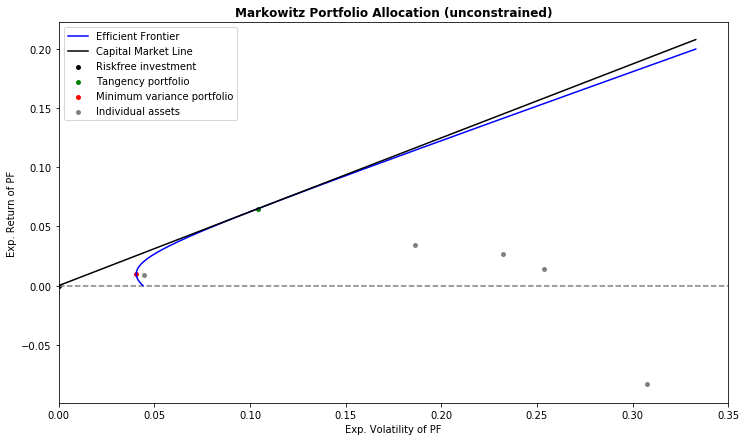

In [118]:
# Visualization - not graded
# --------------------------
import matplotlib.pyplot as plt


# Print interesting statistics like weights, exp. returns and variance of the minimum variance and tangency portfolio
#
print()
print('Unconstrained Markowitz Optimization')
print('====================================')
print()
print('Minimum Variance Portfolio')
print('--------------------------')
print('Weights:         ', np.round(w_mvp.getT(), 2))
print('Exp. Return:     ', np.round(mu_mvp, 2))
print('Exp. Volatility: ', np.round(sigma_mvp, 2))
print()
print('Tangency Portfolio')
print('------------------')
print('Weights          : ', np.round(w_tp, 2))
print('Exp. Return      : ', np.round(mu_tp, 2))
print('Exp. Volatility  : ', np.round(sigma_tp, 2))
print('Exp. Sharpe Ratio: ', np.round( (mu_tp - riskfree)/sigma_tp, 2 ) )
print()


# Plot the portfolios defining the efficient frontier
#
plt.figure(3, figsize = (12, 7))

# Add a horizontal line at the 0 return
plt.axhline(y = 0, linestyle = '--', color = 'gray')

# Add the efficient frontier
plt.plot(sigma_ef, mu_ef, color = 'blue', label = 'Efficient Frontier')

# Add the capital market line
sharpe_tp = ( (mu_tp - riskfree) / sigma_tp )
cx = np.linspace(0.0, np.max(sigma_ef))
plt.plot(cx, riskfree + sharpe_tp * cx, color = 'black', label = 'Capital Market Line')

# Add the risk free rate
plt.scatter([0], [riskfree], s = 15, color = 'black', label = 'Riskfree investment')

# Add the tangency portfolio
plt.scatter([sigma_tp], [mu_tp], s = 15, color = 'green', label = 'Tangency portfolio')

# Add the mvp portfolio
plt.scatter([sigma_mvp], [mu_mvp], s = 15, color = 'red', label = 'Minimum variance portfolio')

# Add the single assets
plt.scatter(std_annual.values, avg_ret_annual.values, s = 15, color = 'gray', label = 'Individual assets')

# Describe the axis
plt.xlabel('Exp. Volatility of PF')
plt.ylabel('Exp. Return of PF')

# Set x axis boundaries
plt.xlim((0, 0.35))

# Add a title
plt.title('Markowitz Portfolio Allocation (unconstrained)', fontweight = 'bold')

# Add a legend
plt.legend()

plt.show()
